In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf, LaTeXStrings

In [3]:
FILE_F_MAP = "../test/datatest/F_REFERENCE.txt"
FILE_PS = "../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)

I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../test/datatest/file_pk.txt"
# F window function input file : "../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 comoving z_eff = 0.15045636096023224 
# 	 Volume of the survey V_survey = 3.845366167995967e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
L=1;

In [5]:
IMPLEMENTED_GR_EFFECTS = [
     "auto_doppler", "auto_lensing",
     "auto_localgp", "auto_integratedgp",

     "lensing_doppler", "doppler_lensing",
     "doppler_localgp", "localgp_doppler",
     "doppler_integratedgp",  "integratedgp_doppler",
     "lensing_localgp", "localgp_lensing",
     "lensing_integratedgp",  "integratedgp_lensing",
     "localgp_integratedgp", "integratedgp_localgp",
];

ξs_names = [
    L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=%$L}(s)$", 
    L"$\xi^{\kappa \, \kappa}_{L=%$L}(s)$", 
    L"$\xi^{\phi \, \phi}_{L=%$L}(s)$", 
    L"$\xi^{\int\phi \, \int\phi}_{L=%$L}(s)$", 
    
    L"$\xi^{\kappa \, v_{\parallel}}_{L=%$L}(s)$",
    L"$\xi^{v_{\parallel} \, \kappa}_{L=%$L}(s)$",
    
    L"$\xi^{v_{\parallel} \, \phi}_{L=%$L}(s)$",
    L"$\xi^{\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L"$\xi^{v_{\parallel} \, \int\phi}_{L=%$L}(s)$",
    L"$\xi^{\int\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L"$\xi^{\kappa \, \phi}_{L=%$L}(s)$",
    L"$\xi^{\phi \, \kappa}_{L=%$L}(s)$",
    
    L"$\xi^{\kappa \, \int\phi}_{L=%$L}(s)$",
    L"$\xi^{\int\phi \, \kappa}_{L=%$L}(s)$",
    
    L"$\xi^{\phi \, \int\phi}_{L=%$L}(s)$",
    L"$\xi^{\int\phi \, \phi}_{L=%$L}(s)$",
]

negatives = [
    "auto_localgp", "auto_integratedgp",

    "lensing_doppler", "doppler_lensing",
    "localgp_integratedgp", "integratedgp_localgp",
];

INDEX_GR_EFFECT = Dict([name => i for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);
GR_EFFECT_INDEXED = Dict([i => name for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);

In [6]:
my_path = "ALL_CF_L" * "$L" * "_files/"
my_files = my_path .* [
    "xi_auto_doppler_L$L.txt", "xi_auto_lensing_L$L.txt",
    "xi_auto_localgp_L$L.txt", "xi_auto_integratedgp_L$L.txt", 
    
    "xi_lensing_doppler_L$L.txt", "xi_doppler_lensing_L$L.txt",
    "xi_doppler_localgp_L$L.txt", "xi_localgp_doppler_L$L.txt",
    "xi_doppler_integratedgp_L$L.txt", "xi_integratedgp_doppler_L$L.txt",
    "xi_lensing_localgp_L$L.txt", "xi_localgp_lensing_L$L.txt",
    "xi_lensing_integratedgp_L$L.txt", "xi_integratedgp_lensing_L$L.txt", 
    "xi_localgp_integratedgp_L$L.txt", "xi_integratedgp_localgp_L$L.txt",
];

my_dict =  Dict([k => v for (k, v) in 
            zip(IMPLEMENTED_GR_EFFECTS, my_files)]...);

In [7]:
common_kwargs = Dict(
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    );
spec_effect = [
    "auto_lensing", "auto_integratedgp",
    "lensing_doppler", "doppler_lensing",
    "doppler_integratedgp",  "integratedgp_doppler",
    "lensing_localgp", "localgp_lensing",
    "lensing_integratedgp",  "integratedgp_lensing",
    "localgp_integratedgp", "integratedgp_localgp",
];

specific_kwargs = [ effect ∈ spec_effect ? Dict(
    :en => 1e6, :N_χs => 50) : nothing for effect in IMPLEMENTED_GR_EFFECTS]

joint_kwargs = [isnothing(spec) ? common_kwargs : merge(common_kwargs, spec) 
    for spec in specific_kwargs];

In [ ]:
for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    
    GaPSE.print_map_ξ_multipole(
        cosmo, 
        "ALL_CF_L$L"*"_files/xi_"*effect*"_L$L.txt", 
        effect; 
        use_windows = false, L = L,
        joint_kwargs[i]...
    )
end

auto_doppler, L=1: 100%|████████████████████████████████| Time: 0:00:01
auto_lensing, L=1:  10%|███▏                            |  ETA: 0:10:24

In [17]:
my_all_table = [readdlm(file, comments=true) for file in my_files]
my_all_ss = [convert(Vector{Float64}, t[:,1]) for t in my_all_table];
my_all_ξs = [convert(Vector{Float64}, t[:,2]) for t in my_all_table];

In [21]:
#=
mattia_path = "../MATTIA_OUTPUTS/"

mattia_files = mattia_path .* [
    "xi_doppler_L$L.txt", "xi_lensing_L$L.txt",
    "xi_local_L$L.txt", "xi_integrated_L$L.txt", 
    
    "xi_lensing_doppler_L$L.txt", "xi_doppler_lensing_L$L.txt",
    "xi_doppler_local_L$L.txt", "xi_local_doppler_L$L.txt",
    "xi_doppler_integrated_L$L.txt", "xi_integrated_doppler_L$L.txt",
    "xi_lensing_local_L$L.txt", "xi_local_lensing_L$L.txt",
    "xi_lensing_integrated_L$L.txt", "xi_integrated_lensing_L$L.txt", 
    "xi_local_integrated_L$L.txt", "xi_integrated_local_L$L.txt",
];


mattia_dict =  Dict([k => v for (k, v) in 
            zip(IMPLEMENTED_GR_EFFECTS, mattia_files)]...);

mattia_all_table = [readdlm(file) for file in mattia_files]
mattia_all_ss = [convert(Vector{Float64},t[2:end,1]) for t in mattia_all_table];
mattia_all_ξs = [convert(Vector{Float64},t[2:end,2]) for t in mattia_all_table];
=#

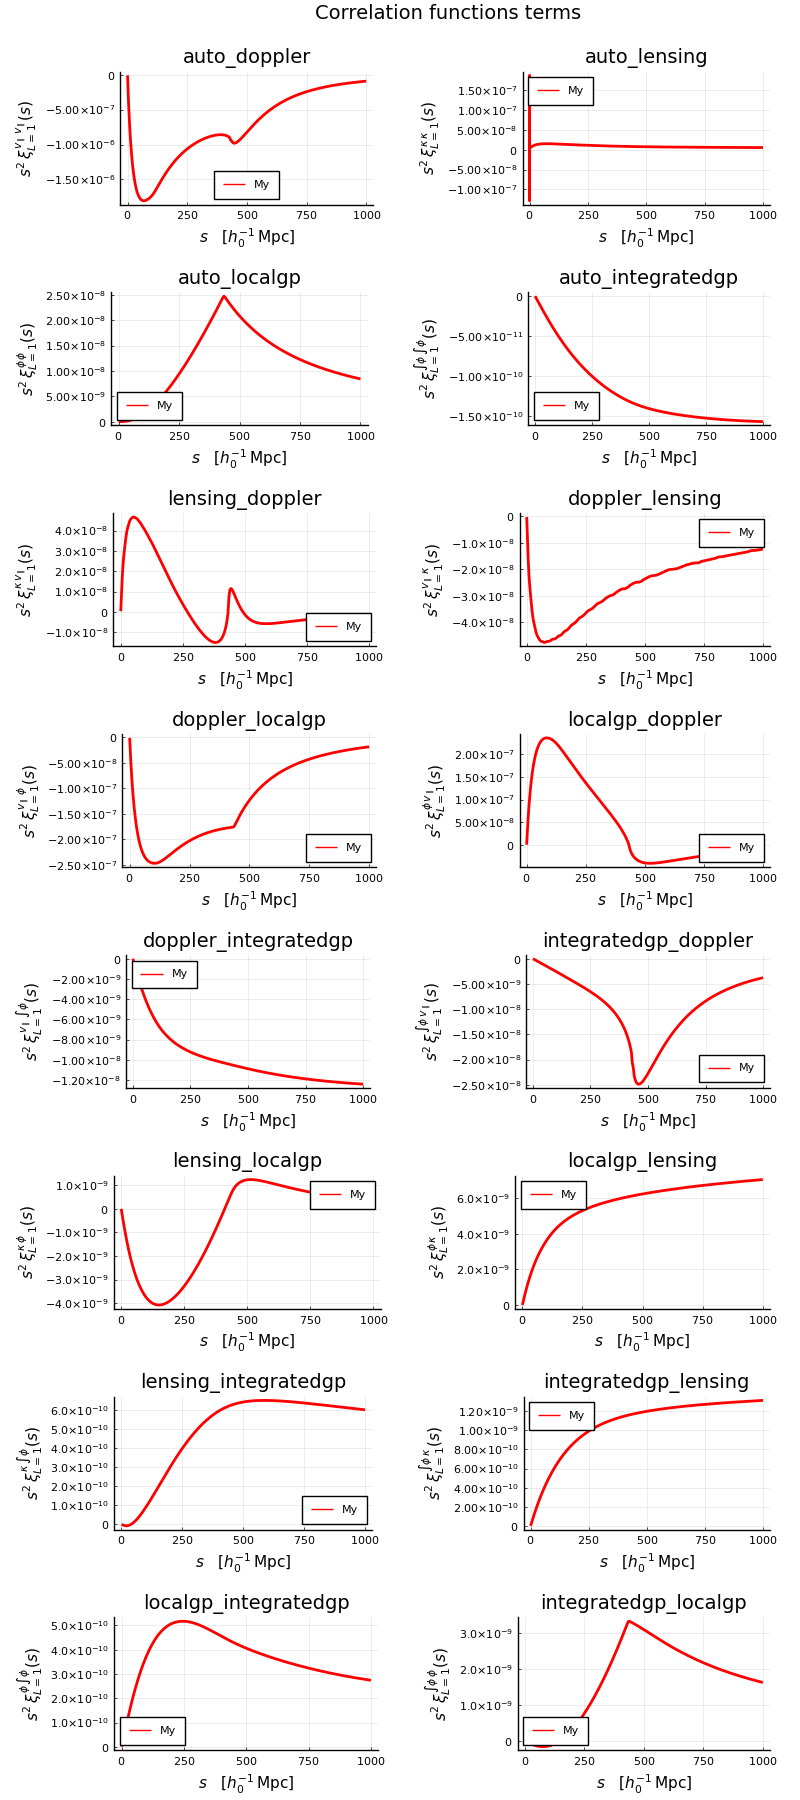

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/matteofoglieni/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [23]:
pyplot()
ps = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "Correlation functions terms", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos_norm=[
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

legend_pos_square=[
    :bottom, :topleft, :bottomleft, :bottomleft,
    :bottomright, :topright, :bottomright, :bottomright,
    :topleft, :bottomright, :topright, :topleft,
    :bottomright, :topleft, :bottomleft, :bottomleft,
]

for i in 1:length(IMPLEMENTED_GR_EFFECTS)
    my_xs = my_all_ss[i]
    my_ys = my_all_ξs[i]
    
    #ot_xs = mattia_all_ss[i]
    #ot_ys = mattia_all_ξs[i]
    ps[i] = plot(
        my_xs, my_ys,
        #[my_xs, ot_xs], 
        #[my_ys .* my_xs .^2, ot_ys .* ot_xs .^2],
        size=(300, 100),
        lw=2, lc="red", ls=:solid,
        label = "My" ,
        title=IMPLEMENTED_GR_EFFECTS[i], 
        legend=legend_pos_square[i],
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, " * ξs_names[i],
        #xaxis=:log,
        top_margins=15Plots.px,
        #yaxis=nothing,
        #yaxis=:log,
    )
end

l = @layout [A{0.05h}; a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(800,1800))

In [12]:
#GaPSE.print_map_ξ_multipole(cosmo, "ALL_CF_files/xi_lensing_doppler_L0.txt", 
#    "lensing_doppler"; use_windows = false, N_χs = 50, N_μs = 30)

In [24]:
i = 5
effect = GR_EFFECT_INDEXED[i]

my_xs = my_all_ss[INDEX_GR_EFFECT[effect]]
xs = mattia_all_ss[INDEX_GR_EFFECT[effect]]

my_ys = my_all_ξs[INDEX_GR_EFFECT[effect]] 
ys = mattia_all_ξs[INDEX_GR_EFFECT[effect]]
spline = Spline1D(xs, ys)

S_VLIM = cosmo.s_eff
S_VLIM_F = @sprintf("%.2f", S_VLIM)

pyplot()
p1 = plot(
    [my_xs, xs], 
    [my_ys .* my_xs .^2, ys .* xs .^2], 
    #xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], 
    label=["My" "Mattia"], title=effect,
    ylabel=L"$s^2 \;$" * ξs_names[INDEX_GR_EFFECT[effect]],
    ls=[:dash :solid], legend=legend_pos_square[INDEX_GR_EFFECT[effect]])
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, lc=:green, #xaxis=:log,
    ylim=(0.99,1.01), legend=false, ylabel="ratio",
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 400), layout= @layout [ x ; z ] )
#savefig(P, "xi_"*"$effect"*"_L0.pdf")
#display(P)

LoadError: UndefVarError: mattia_all_ss not defined

In [14]:
#=
for effect in IMPLEMENTED_GR_EFFECTS
    tit = effect * " * s^2"
    my_xs = my_all_ss[INDEX_GR_EFFECT[effect]]
    xs = mattia_all_ss[INDEX_GR_EFFECT[effect]]

    #sign = effect ∈ negatives ? -1.0 : 1.0
    my_ys = my_all_ξs[INDEX_GR_EFFECT[effect]] .* my_xs.^2
    ys = mattia_all_ξs[INDEX_GR_EFFECT[effect]] .* xs.^2
    spline = Spline1D(xs, ys)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot([my_xs, xs], [my_ys,  ys], #xaxis=:log, yaxis=:log, 
        lc=[:red :blue], 
        label=["My" "Mattia"], title=tit,
        ls=[:dash :solid], legend=:bottomleft)
    vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
        ylim=(0.99,1.01), legend=:topleft, 
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    P = plot(p1, p2, size=(550, 400), layout= @layout [ x ; z ] )
    savefig(P, "xi_"*"$effect"*"_L0.pdf")
end
=#

In [15]:
pyplot()

LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]
for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = "\n\n"*effect
    my_xs = my_all_ss[INDEX_GR_EFFECT[effect]]
    xs = mattia_all_ss[INDEX_GR_EFFECT[effect]]

    #sign = effect ∈ negatives ? -1.0 : 1.0
    my_ys = my_all_ξs[INDEX_GR_EFFECT[effect]] .* my_xs.^2
    ys = mattia_all_ξs[INDEX_GR_EFFECT[effect]] .* xs.^2
    spline = Spline1D(xs, ys)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot([my_xs, xs], [my_ys,  ys], #xaxis=:log, #yaxis=:log, 
        lc=[:red :blue], 
        label=["My" "Mattia"], title=tit,
        ylabel=L"s^2 \," * ξs_names[i],
        ls=[:dash :dot], legend=legend_pos_square[i])
    vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", 
        lc=:green, #xaxis=:log,
        ylim=(0.99,1.01), legend=:false, 
        ylabel="ratio",
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
ALL_PLOTS = plot(LIST_P..., layout=grid(8,2),
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1200,4000))
savefig(ALL_PLOTS, "ALL_CF.pdf")
display(ALL_PLOTS)

LoadError: UndefVarError: my_all_ss not defined